In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

# loading data

In [2]:

def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

SIZE = 256
high_img = []
path = '../input/image-super-resolution/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)

for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '../input/image-super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:08<00:00, 104.64it/s]


# data visualisation


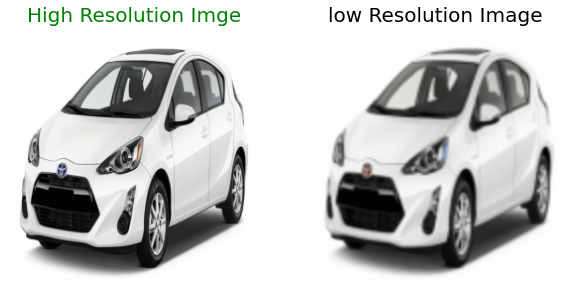

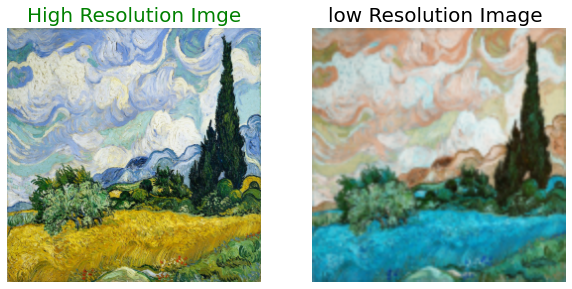

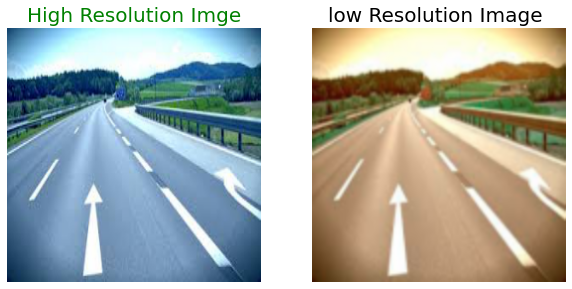

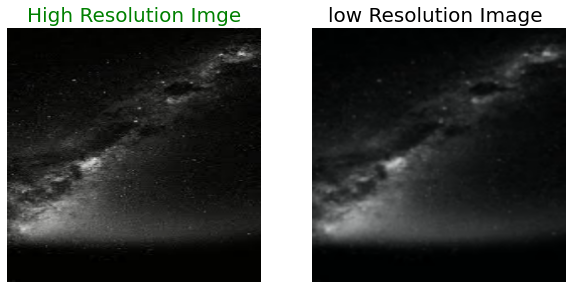

In [3]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

# slicing and reshaping

In [4]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)


Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


# defining model

In [5]:
from tensorflow.keras import layers
import tensorflow

def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    downsample.add(layers.Dropout(.2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(tensorflow.keras.layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    upsample.add(layers.Dropout(.2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(tensorflow.keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tensorflow.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

2022-12-22 06:29:27.064991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 06:29:27.200557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 06:29:27.201476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 06:29:27.203355: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  296192      sequential_1[0][0]               
______________________________________________________________________________________________

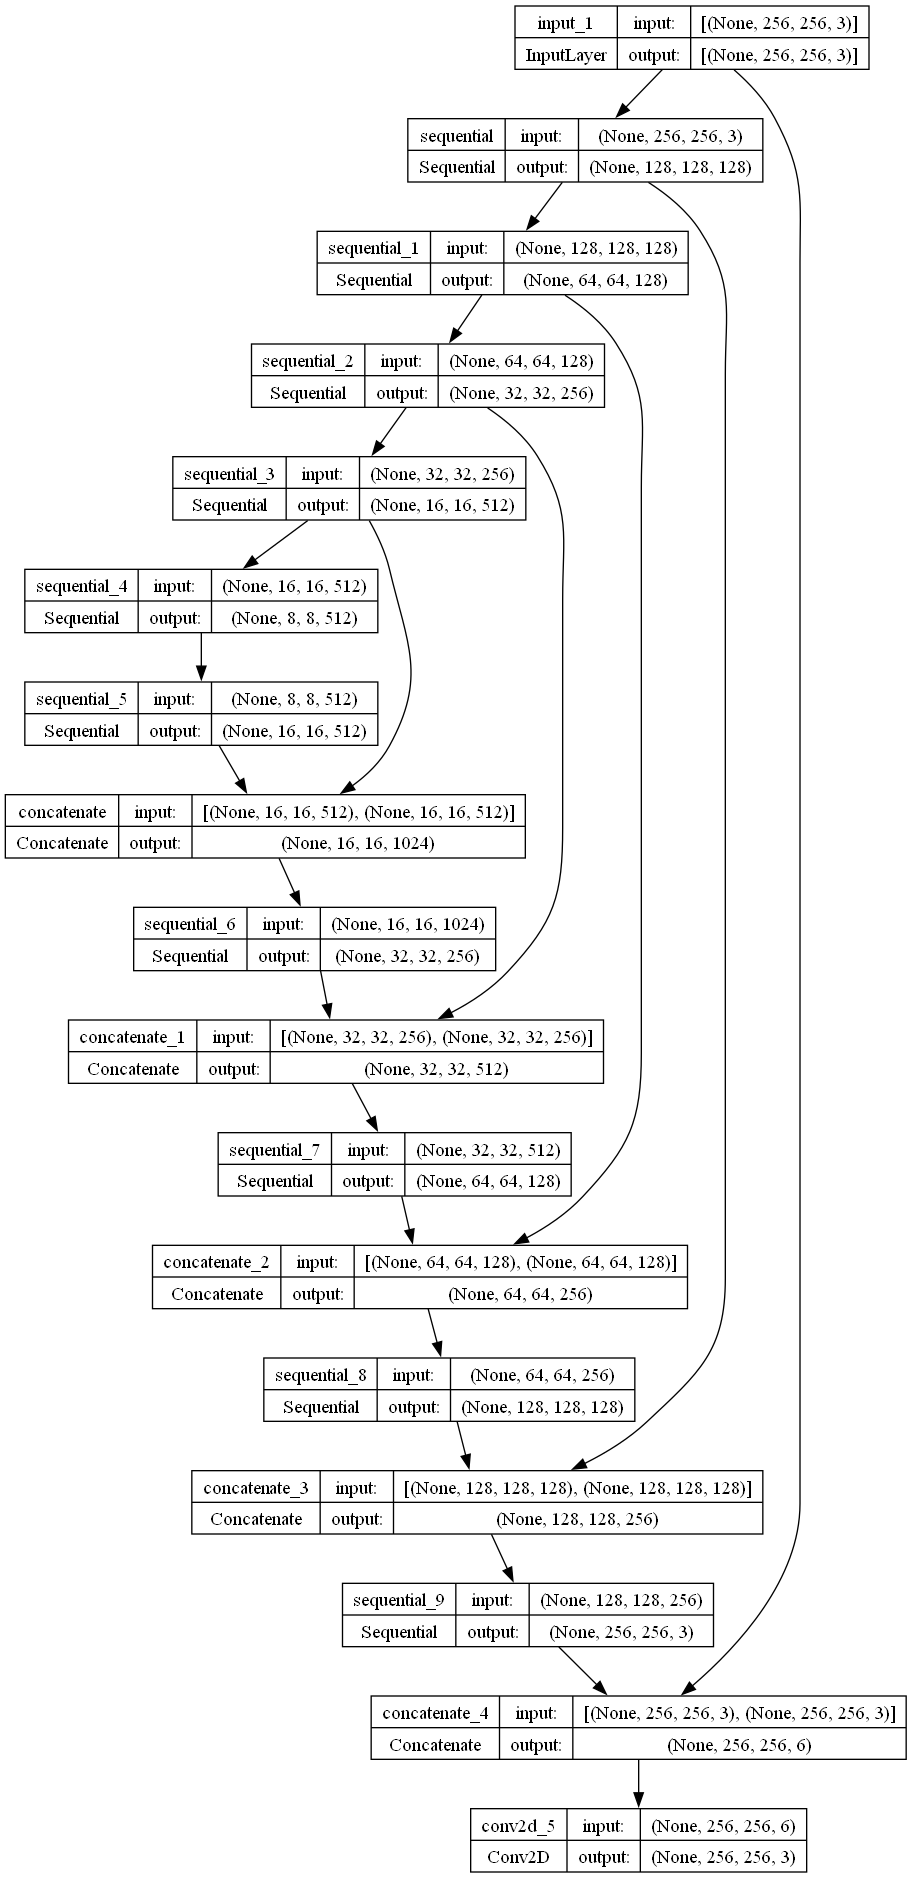

In [1]:
from keras.utils import plot_model
from keras.models import load_model

model = load_model("image_super_resolution_cnn_final_model.h5")
plot_model(model, to_file='image_super_resolution_cnn_plot.png', show_shapes=True, show_layer_names=True)

# compile

In [6]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

# fitting model

In [7]:
model.fit(train_low_image, train_high_image, epochs = 30, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

2022-12-22 06:29:32.521897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-12-22 06:29:34.479784: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


700/700 [==============================] - 20s 18ms/step - loss: 0.0542 - acc: 0.6430 - val_loss: 0.0355 - val_acc: 0.8079
Epoch 2/30
700/700 [==============================] - 12s 16ms/step - loss: 0.0315 - acc: 0.7600 - val_loss: 0.0234 - val_acc: 0.7995
Epoch 3/30
700/700 [==============================] - 12s 17ms/step - loss: 0.0264 - acc: 0.8038 - val_loss: 0.0211 - val_acc: 0.8008
Epoch 4/30
700/700 [==============================] - 12s 16ms/step - loss: 0.0236 - acc: 0.8275 - val_loss: 0.0198 - val_acc: 0.8535
Epoch 5/30
700/700 [==============================] - 11s 16ms/step - loss: 0.0223 - acc: 0.8254 - val_loss: 0.0202 - val_acc: 0.8982
Epoch 6/30
700/700 [==============================] - 12s 17ms/step - loss: 0.0212 - acc: 0.8330 - val_loss: 0.0179 - val_acc: 0.8356
Epoch 7/30
700/700 [==============================] - 11s 16ms/step - loss: 0.0205 - acc: 0.8336 - val_loss: 0.0179 - val_acc: 0.8504
Epoch 8/30
700/700 [==============================] - 11s 16ms/step - los

# predict visulisation

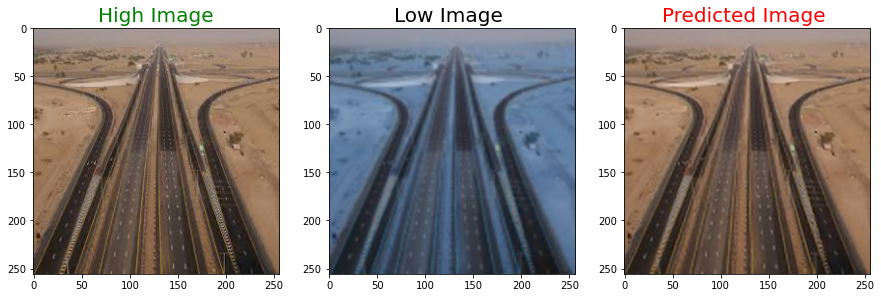

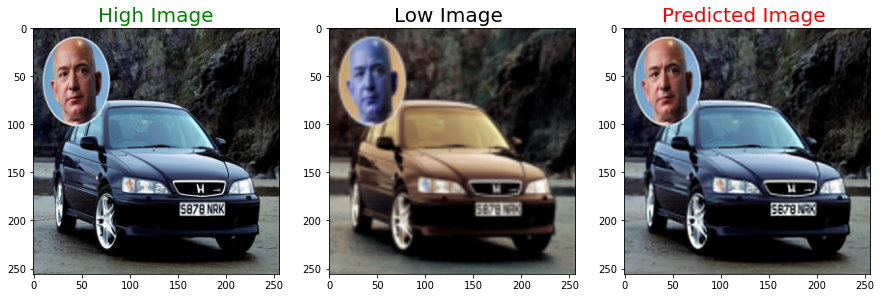

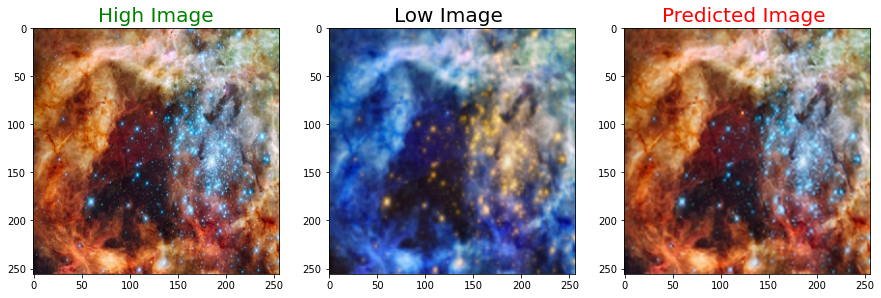

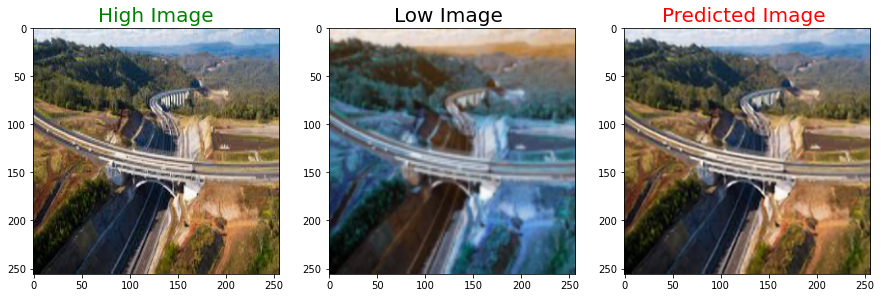

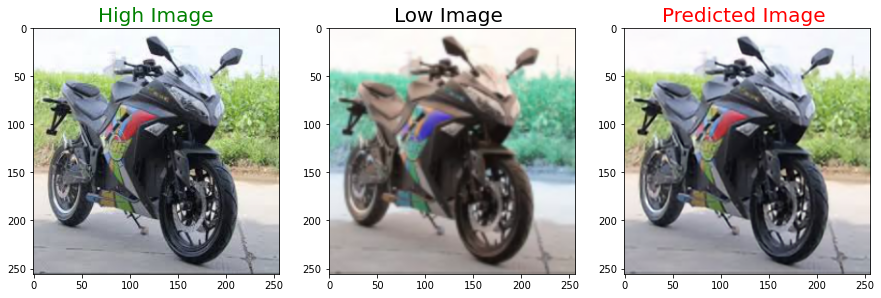

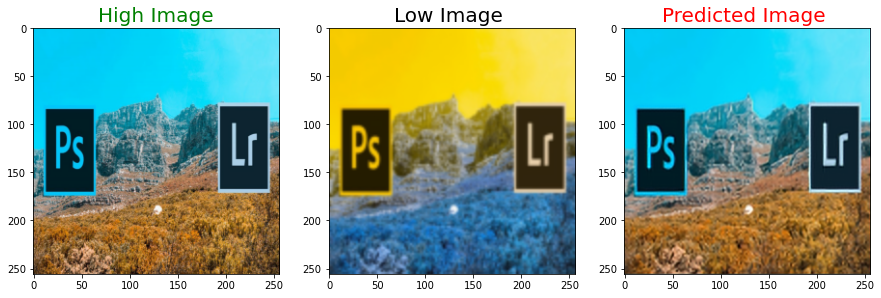

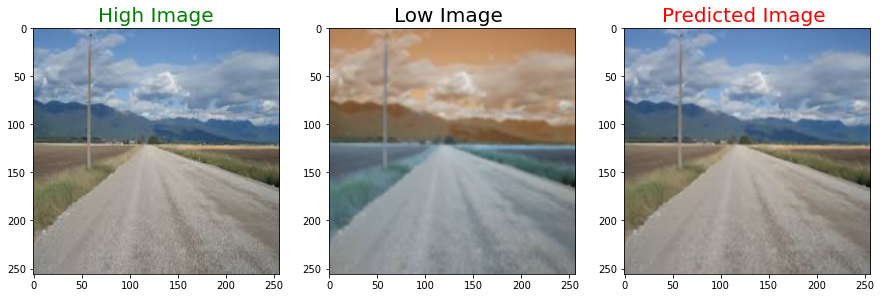

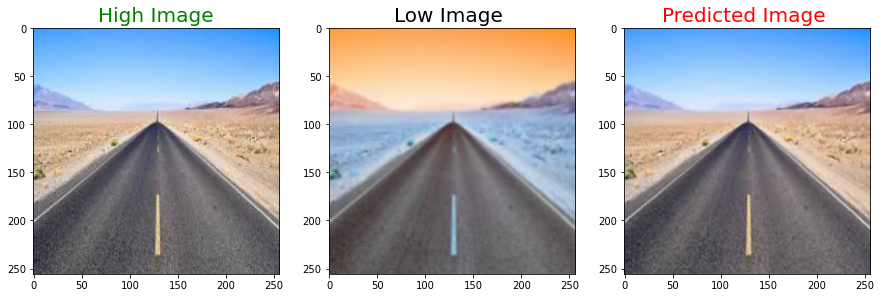

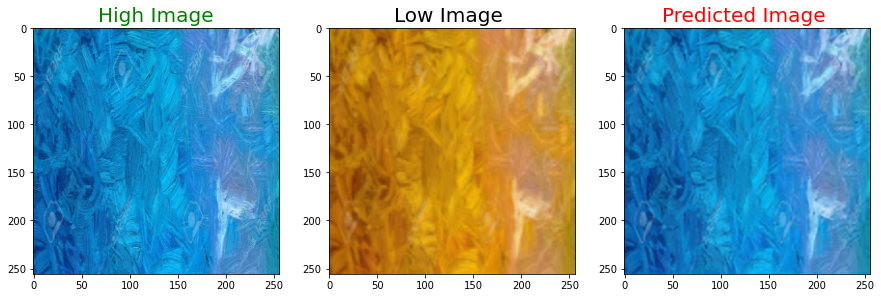

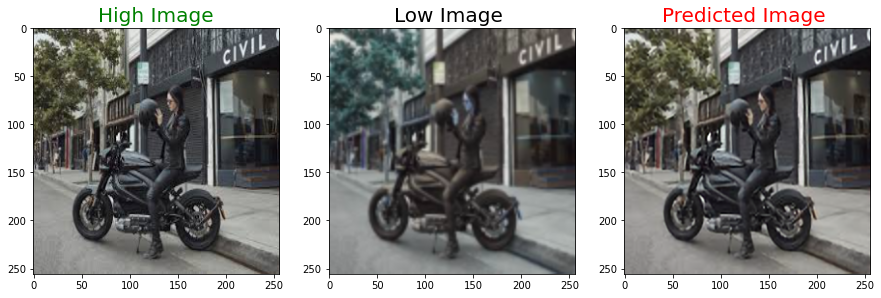

In [8]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(0,10):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [9]:
model.save("final_model.h5")

# metrics

In [10]:
psnr2=0
ssim2 = 0
for i in range(0,10):
    im1 = model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3))
    im2 = test_low_image[i]
    im1 = tf.image.convert_image_dtype(im1, tf.float32)
    im2 = tf.image.convert_image_dtype(im2, tf.float32)
    psnr2 += tf.image.psnr(im1, im2, max_val=1.0)
    ssim2 += tf.image.ssim(im1, im2, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
psnr2 =psnr2/10
ssim2 = ssim2/10
psnr2



<tf.Tensor: shape=(1,), dtype=float32, numpy=array([15.407956], dtype=float32)>

In [11]:
ssim2

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.755792], dtype=float32)>